In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display

# Local
from utils.misc import dict_to_object, plot_specgram, plot_waveform
from utils.audio import spectogram, load_mono_audio
from utils.alignment import init_alignment, alignment
from vocoder.model import Generator
from voicebox.model_audio import AudioModel
from voicebox.tokenizer import Tokenizer
from train_config import config

In [2]:
# Tokenizer
tokenizer = Tokenizer()

# Load index
files = glob("datasets/vctk-aligned/**/*.TextGrid")
files = [f[len("datasets/vctk-aligned/"):-len(".TextGrid")] for f in files]

# First 10
files = files[0:10]

# Load textgrids
tg = [textgrid.TextGrid.fromFile("datasets/vctk-aligned/" + f + ".TextGrid") for f in files]

# Load audio
files = ["datasets/vctk-prepared/" + f + ".wav" for f in files]

In [3]:
# Tokenizer
tokenizer = Tokenizer()

# Data extractor
def extract_tokens(src):

    # Prepare
    token_duration = 0.01
    tokens = src[1]
    time = 0
    output_tokens = []
    output_durations = []

    # Iterate over tokens
    for t in tokens:

        # Resolve durations
        ends = t.maxTime
        duration = math.floor((ends - time) / token_duration)
        time = ends

        # Resolve token
        tok = t.mark
        if tok == '':
            tok = tokenizer.silence_token

        # Apply
        output_tokens.append(tok)
        output_durations.append(duration)

    # Trim start silence
    if output_tokens[0] == 'SIL' and output_durations[0] > 1:
        output_durations[0] = 1
    if output_tokens[len(output_tokens) - 1] == 'SIL' and output_durations[len(output_durations) - 1] > 1:
        output_durations[len(output_durations) - 1] = 1

     # Phonemes
    phonemes = []
    for t in range(len(output_tokens)):
        tok = output_tokens[t]
        for i in range(output_durations[t]):
            phonemes.append(tok)
    tokens = tokenizer(phonemes)

    # Outputs
    return tokens, phonemes


In [4]:
device = "cuda:1"

# Audio model
model = AudioModel(tokenizer.n_tokens)
model = model.to(device)
checkpoint = torch.load(f'./checkpoints/audio_alibi.pt', map_location="cpu")
model.load_state_dict(checkpoint['model'])

# Vocoder
generator = Generator(config).to(device)
data = torch.load("./checkpoints/vocoder_vctk.pt", map_location="cpu")
generator.load_state_dict(data['generator'])
generator.eval()
generator.remove_weight_norm()

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


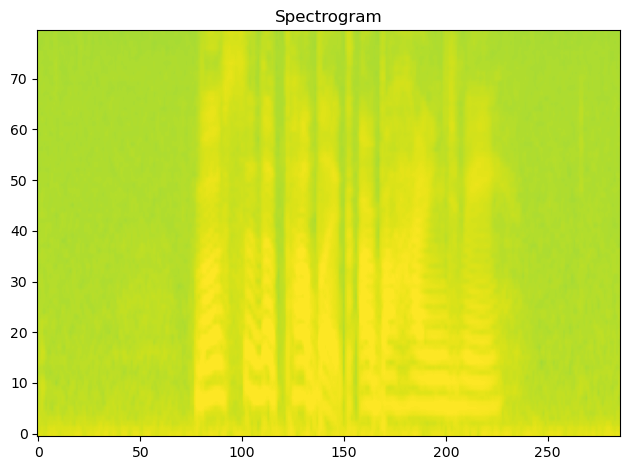

In [16]:
# Load audio
waveform = load_mono_audio(files[3], sample_rate = config.audio.sample_rate)
spec = spectogram(waveform, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)

# Load tokens
x, toks = extract_tokens(tg[3])
x = x.to(device)
y = torch.zeros((len(x), 80)).to(device)
mask = torch.ones((len(x))).bool().to(device)

# Source audio
plot_specgram(spec.cpu())

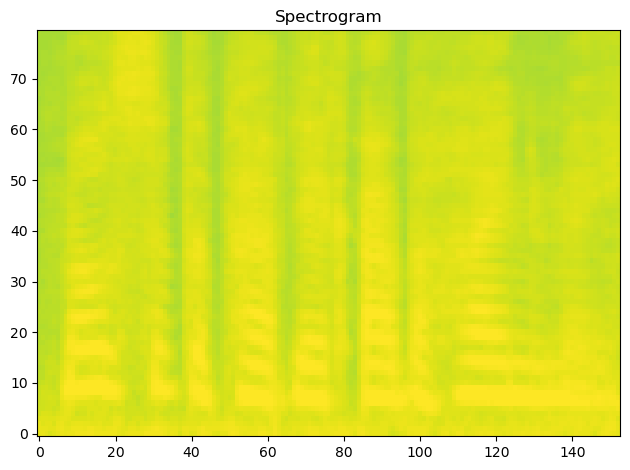

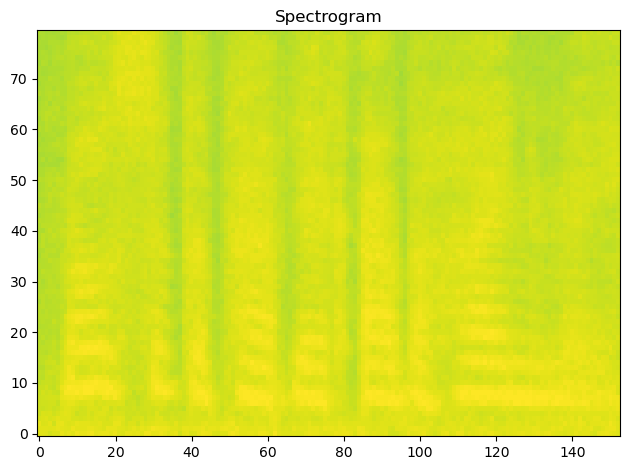

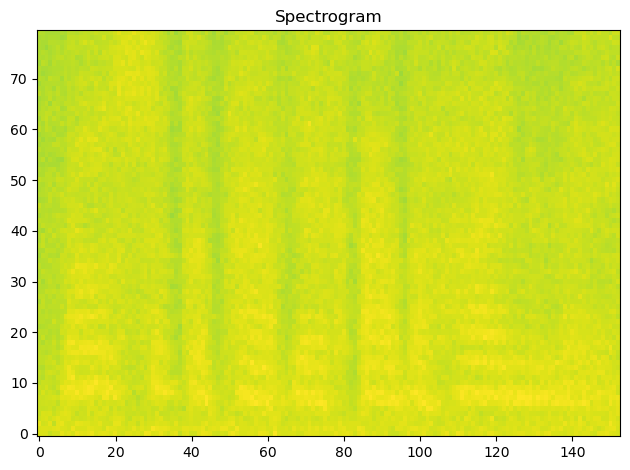

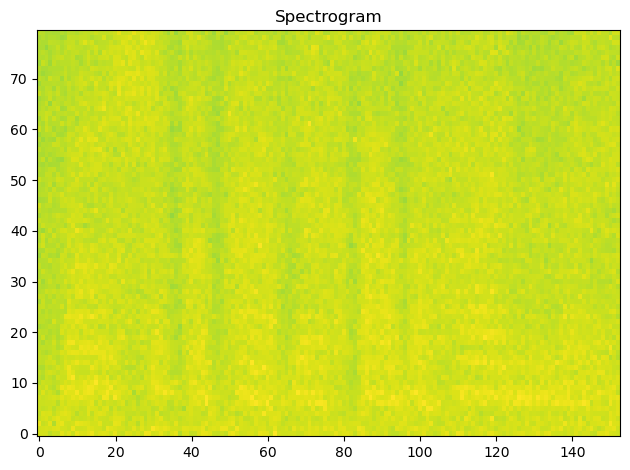

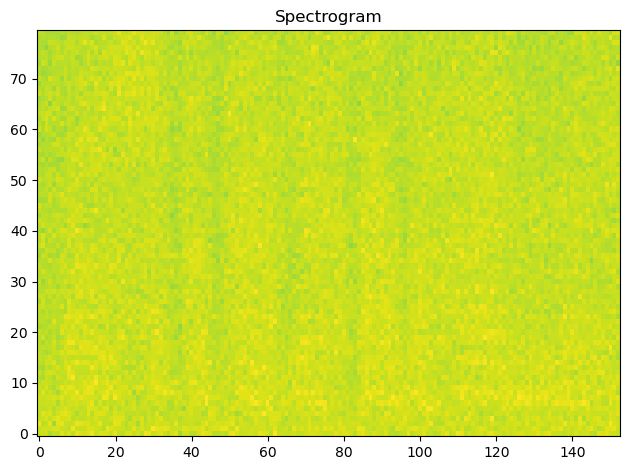

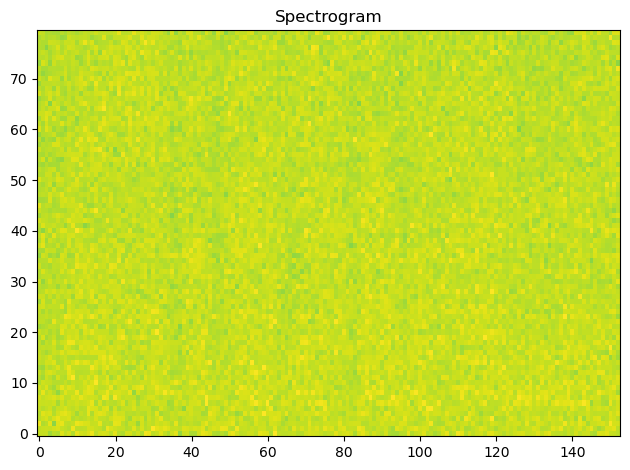

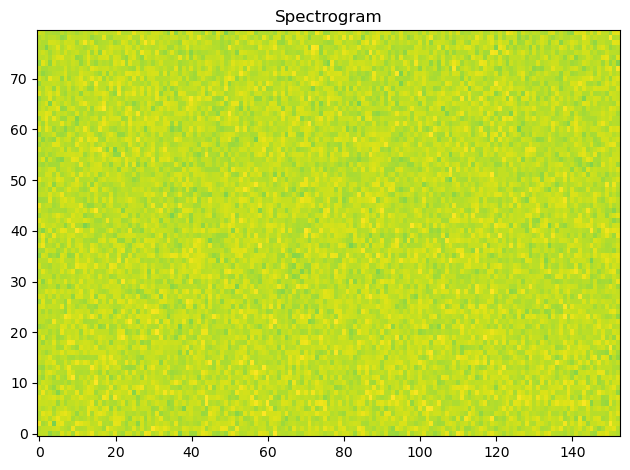

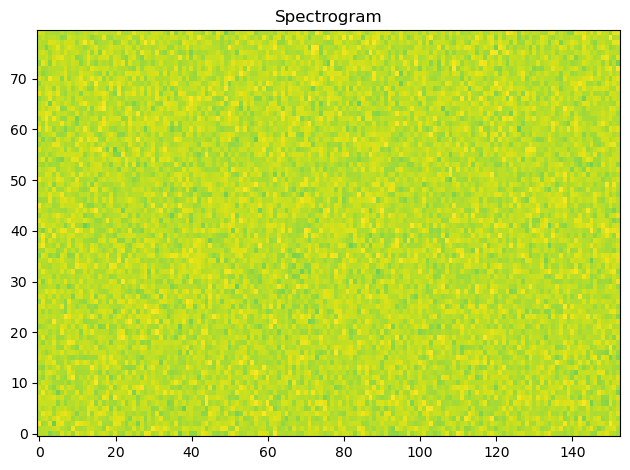

In [18]:
model.eval()
with torch.no_grad():
    sample, trajectory = model.sample(x, y, mask, steps = 8)
    sample = (sample * 2.2615) + (-5.8843)
    trajectory = (trajectory * 2.2615) + (-5.8843)

# Resynth
resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    